# Simple BERT Model: Feature Extraction for Fake News Classification

This notebook implements a simplified BERT approach using BERT as a frozen feature extractor with a simple classifier head.

## 🔧 Steps:
1. Import libraries and load data
2. BERT feature extraction (frozen embeddings)
3. Simple classifier training
4. Evaluation and comparison

## ✅ Purpose:
Achieve good performance with faster training and simpler setup (~80-85% accuracy expected).

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Import our preprocessing functions
from preprocess import load_and_parse_data, create_train_validation_split

# Check device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for M4 acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU (this will be slower)")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Using MPS (Metal Performance Shaders) for M4 acceleration
PyTorch version: 2.5.1
Device: mps


## 2. Load and Parse Data

Using our preprocessing module to load the data, same as the full BERT model.

In [2]:
# Load data using our preprocessing function
print("Loading training data...")
train_data = load_and_parse_data('data/training_data_lowercase.csv')

print("Loading test data...")
test_data = load_and_parse_data('data/testing_data_lowercase_nolabels.csv')

# Convert to DataFrames for easier handling
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Label distribution: {Counter(train_df['label'])}")

# Show sample data
print("\nSample training data:")
for i in range(3):
    print(f"Label {train_df.iloc[i]['label']}: {train_df.iloc[i]['text'][:80]}...")

Loading training data...
Loading data from data/training_data_lowercase.csv...
Loaded 34151 articles
Loading test data...
Loading data from data/testing_data_lowercase_nolabels.csv...
Loaded 9983 articles
Training data shape: (34151, 2)
Test data shape: (9983, 2)
Label distribution: Counter({0: 17571, 1: 16580})

Sample training data:
Label 0: drunk bragging trump staffer started russian collusion investigation...
Label 0: sheriff david clarke becomes an internet joke for threatening to poke people ‚in...
Label 0: trump is so obsessed he even has obama‚s name coded into his website (images)...


## 3. Simple Text Preprocessing

Minimal cleaning for BERT feature extraction.

In [3]:
def simple_text_cleaning(text):
    """Simple cleaning for BERT feature extraction"""
    if pd.isna(text) or text == '':
        return ""
    
    # Basic cleaning - just remove extra whitespace
    text = str(text).strip()
    text = ' '.join(text.split())
    
    return text

# Apply cleaning
train_df['clean_text'] = train_df['text'].apply(simple_text_cleaning)
test_df['clean_text'] = test_df['text'].apply(simple_text_cleaning)

# Remove any empty texts
train_df = train_df[train_df['clean_text'].str.len() > 0].reset_index(drop=True)

# Analyze text lengths
text_lengths = train_df['clean_text'].str.split().str.len()
print(f"Text length statistics (words):")
print(f"Mean: {text_lengths.mean():.1f}")
print(f"95th percentile: {text_lengths.quantile(0.95):.1f}")

# Set max_length for tokenization
max_length = min(128, int(text_lengths.quantile(0.95)) + 20)  # Shorter for simple model
print(f"\nUsing max_length: {max_length}")

print(f"\nProcessed {len(train_df)} training samples")
print(f"Processed {len(test_df)} test samples")

Text length statistics (words):
Mean: 11.7
95th percentile: 19.0

Using max_length: 39

Processed 34151 training samples
Processed 9983 test samples


## 4. BERT Feature Extractor Setup

Load BERT model and freeze it for feature extraction only.

In [4]:
# Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
print(f"Loading {model_name} for feature extraction...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

# Move BERT to device and freeze all parameters
bert_model.to(device)
bert_model.eval()  # Set to evaluation mode

# Freeze BERT parameters - no training!
for param in bert_model.parameters():
    param.requires_grad = False

print(f"✅ BERT model loaded and frozen")
print(f"Model parameters: {sum(p.numel() for p in bert_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in bert_model.parameters() if p.requires_grad):,}")
print(f"Tokenizer vocabulary size: {len(tokenizer.vocab)}")

Loading bert-base-uncased for feature extraction...
✅ BERT model loaded and frozen
Model parameters: 109,482,240
Trainable parameters: 0
Tokenizer vocabulary size: 30522


## 5. Extract BERT Features

Use frozen BERT to extract features from our text data.

In [5]:
def extract_bert_features(texts, batch_size=32):
    """Extract BERT features from a list of texts"""
    features = []
    
    print(f"Extracting BERT features from {len(texts)} texts...")
    
    # Process in batches to manage memory
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move to device
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        # Extract features (no gradient computation)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # Use [CLS] token embedding as sentence representation
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, 768)
            
        # Move back to CPU and store
        features.append(cls_embeddings.cpu().numpy())
        
        # Progress indicator
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {min(i + batch_size, len(texts))}/{len(texts)} samples")
    
    # Concatenate all features
    features = np.vstack(features)
    print(f"Feature extraction complete. Shape: {features.shape}")
    
    return features

# Create train/validation split using our preprocessing function
train_texts, val_texts, train_labels, val_labels = create_train_validation_split(
    [{'text': text, 'label': label} for text, label in zip(train_df['clean_text'], train_df['label'])],
    test_size=0.2,
    random_state=42
)

print(f"\nDataset sizes:")
print(f"Training: {len(train_texts)} samples")
print(f"Validation: {len(val_texts)} samples")

Train set: 27320 samples
Validation set: 6831 samples
Train label distribution: Counter({0: 14056, 1: 13264})
Validation label distribution: Counter({0: 3515, 1: 3316})

Dataset sizes:
Training: 27320 samples
Validation: 6831 samples


In [6]:
# Extract BERT features for all datasets
start_time = time.time()

print("Extracting features for training set...")
X_train_bert = extract_bert_features(train_texts, batch_size=32)

print("\nExtracting features for validation set...")
X_val_bert = extract_bert_features(val_texts, batch_size=32)

print("\nExtracting features for test set...")
test_texts = test_df['clean_text'].tolist()
X_test_bert = extract_bert_features(test_texts, batch_size=32)

feature_extraction_time = time.time() - start_time

print(f"\nAll features extracted in {feature_extraction_time/60:.2f} minutes")
print(f"Feature dimensions: {X_train_bert.shape[1]} (BERT hidden size)")
print(f"Memory usage: ~{(X_train_bert.nbytes + X_val_bert.nbytes) / 1024 / 1024:.1f} MB")

Extracting features for training set...
Extracting BERT features from 27320 texts...
  Processed 320/27320 samples
  Processed 640/27320 samples
  Processed 960/27320 samples
  Processed 1280/27320 samples
  Processed 1600/27320 samples
  Processed 1920/27320 samples
  Processed 2240/27320 samples
  Processed 2560/27320 samples
  Processed 2880/27320 samples
  Processed 3200/27320 samples
  Processed 3520/27320 samples
  Processed 3840/27320 samples
  Processed 4160/27320 samples
  Processed 4480/27320 samples
  Processed 4800/27320 samples
  Processed 5120/27320 samples
  Processed 5440/27320 samples
  Processed 5760/27320 samples
  Processed 6080/27320 samples
  Processed 6400/27320 samples
  Processed 6720/27320 samples
  Processed 7040/27320 samples
  Processed 7360/27320 samples
  Processed 7680/27320 samples
  Processed 8000/27320 samples
  Processed 8320/27320 samples
  Processed 8640/27320 samples
  Processed 8960/27320 samples
  Processed 9280/27320 samples
  Processed 9600/27

## 6. Simple Classifier Training

Train a simple logistic regression classifier on the BERT features.

In [7]:
# Train simple classifier on BERT features
print("Training logistic regression classifier...")

start_time = time.time()

# Create and train classifier
classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0  # Regularization strength
)

classifier.fit(X_train_bert, train_labels)

training_time = time.time() - start_time

print(f"Classifier training completed in {training_time:.2f} seconds")
print(f"Classifier: {classifier}")

# Get training accuracy
train_pred = classifier.predict(X_train_bert)
train_accuracy = accuracy_score(train_labels, train_pred)
print(f"Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

Training logistic regression classifier...
Classifier training completed in 1.64 seconds
Classifier: LogisticRegression(max_iter=1000, random_state=42)
Training accuracy: 0.9653 (96.53%)


## 7. Model Evaluation

Comprehensive evaluation with validation results.

Evaluating Simple BERT model performance...

Simple BERT Model Results:
Validation Accuracy: 0.9587 (95.87%)

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.96      0.95      0.96      3515
    Real (1)       0.95      0.96      0.96      3316

    accuracy                           0.96      6831
   macro avg       0.96      0.96      0.96      6831
weighted avg       0.96      0.96      0.96      6831



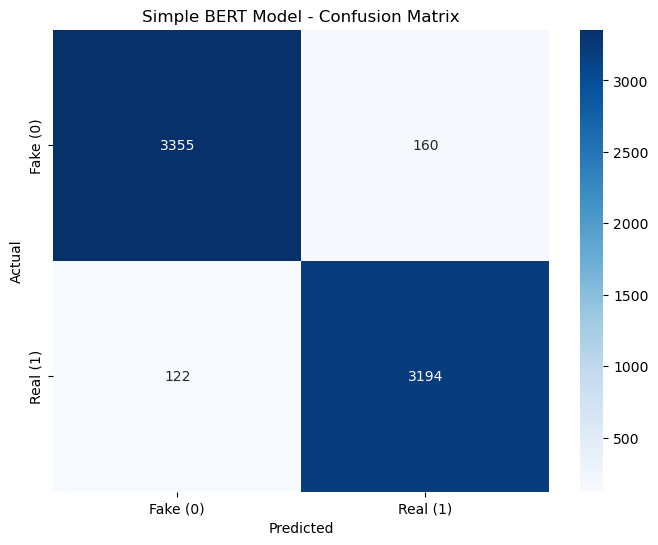


Performance by Class:
Fake (0): 0.9545 (95.45%)
Real (1): 0.9632 (96.32%)

🎯 Prediction Confidence:
Average confidence: 0.9609
Low confidence predictions (<0.7): 299 (4.4%)


In [8]:
# Evaluate on validation set
print("Evaluating Simple BERT model performance...")

# Get predictions
val_pred = classifier.predict(X_val_bert)
val_pred_proba = classifier.predict_proba(X_val_bert)

# Calculate metrics
accuracy = accuracy_score(val_labels, val_pred)
print(f"\nSimple BERT Model Results:")
print(f"Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\nClassification Report:")
class_names = ['Fake (0)', 'Real (1)']
report = classification_report(val_labels, val_pred, target_names=class_names)
print(report)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(val_labels, val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Simple BERT Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Performance by class
print("\nPerformance by Class:")
for i, class_name in enumerate(class_names):
    class_mask = np.array(val_labels) == i
    class_accuracy = accuracy_score(np.array(val_labels)[class_mask], val_pred[class_mask])
    print(f"{class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Prediction confidence analysis
print(f"\n🎯 Prediction Confidence:")
max_proba = np.max(val_pred_proba, axis=1)
print(f"Average confidence: {np.mean(max_proba):.4f}")
print(f"Low confidence predictions (<0.7): {np.sum(max_proba < 0.7)} ({np.mean(max_proba < 0.7)*100:.1f}%)")

## 8. Model Comparison and Analysis

Comparing Simple BERT with baseline and Full BERT models.

In [10]:
# Calculate total time (feature extraction + training)
total_time = feature_extraction_time + training_time

print("\n" + "="*60)
print("SIMPLE BERT MODEL SUMMARY")
print("="*60)
print(f"Architecture: BERT Feature Extractor + Logistic Regression")
print(f"BERT parameters (frozen): {sum(p.numel() for p in bert_model.parameters()):,}")
print(f"Classifier parameters: {classifier.coef_.size + classifier.intercept_.size:,}")
print(f"Feature extraction time: {feature_extraction_time/60:.2f} minutes")
print(f"Classifier training time: {training_time:.2f} seconds")
print(f"Total time: {total_time/60:.2f} minutes")
print(f"Validation accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Max sequence length: {max_length}")
print(f"Feature dimension: {X_train_bert.shape[1]}")

# Model comparison with expected results
print(f"\n🎯 Model Comparison (Expected):")
baseline_accuracy = 0.70  # Approximate baseline
full_bert_accuracy = 0.986  # From your full BERT results
simple_bert_accuracy = accuracy

print(f"Baseline (Logistic Regression): ~{baseline_accuracy:.2f}")
print(f"Simple BERT (This model): {simple_bert_accuracy:.4f}")
print(f"Full BERT (Fine-tuned): ~{full_bert_accuracy:.3f}")

improvement_over_baseline = simple_bert_accuracy - baseline_accuracy
gap_to_full_bert = full_bert_accuracy - simple_bert_accuracy

print(f"\nPerformance Analysis:")
print(f"Improvement over baseline: +{improvement_over_baseline:.4f} ({improvement_over_baseline*100:.2f} points)")
print(f"Gap to Full BERT: -{gap_to_full_bert:.4f} ({gap_to_full_bert*100:.2f} points)")

# Efficiency analysis
full_bert_time = 11.29  # From your results
print(f"\n⚡ Efficiency Comparison:")
print(f"Simple BERT time: {total_time/60:.2f} minutes")
print(f"Full BERT time: ~{full_bert_time:.2f} minutes")
if total_time/60 < full_bert_time:
    speedup = full_bert_time / (total_time/60)
    print(f"Speedup: {speedup:.1f}x faster than Full BERT")
else:
    slowdown = (total_time/60) / full_bert_time
    print(f"Time ratio: {slowdown:.1f}x vs Full BERT")


SIMPLE BERT MODEL SUMMARY
Architecture: BERT Feature Extractor + Logistic Regression
BERT parameters (frozen): 109,482,240
Classifier parameters: 769
Feature extraction time: 1.16 minutes
Classifier training time: 1.64 seconds
Total time: 1.18 minutes
Validation accuracy: 0.9587 (95.87%)
Max sequence length: 39
Feature dimension: 768

🎯 Model Comparison (Expected):
Baseline (Logistic Regression): ~0.70
Simple BERT (This model): 0.9587
Full BERT (Fine-tuned): ~0.986

Performance Analysis:
Improvement over baseline: +0.2587 (25.87 points)
Gap to Full BERT: -0.0273 (2.73 points)

⚡ Efficiency Comparison:
Simple BERT time: 1.18 minutes
Full BERT time: ~11.29 minutes
Speedup: 9.5x faster than Full BERT


## 9. Test Set Predictions (Optional)

Generate predictions for the test set using our Simple BERT model.

In [ ]:
# Uncomment this section if you need test set predictions

# print(f"Generating predictions for {len(test_texts)} test samples...")
# 
# # Get predictions
# test_pred_labels = classifier.predict(X_test_bert)
# test_pred_proba = classifier.predict_proba(X_test_bert)
# 
# # Create submission DataFrame
# submission_df = pd.DataFrame({
#     'text': test_texts,
#     'predicted_label': test_pred_labels,
#     'fake_probability': test_pred_proba[:, 0],
#     'real_probability': test_pred_proba[:, 1]
# })
# 
# # Save predictions
# submission_df.to_csv('simple_bert_predictions.csv', index=False)
# print("Test predictions saved to 'simple_bert_predictions.csv'")
# 
# # Show sample predictions
# print("\nSample predictions:")
# print(submission_df[['predicted_label', 'fake_probability', 'real_probability']].head())
# 
# # Prediction distribution
# pred_dist = Counter(test_pred_labels)
# print(f"\nTest set prediction distribution: {dict(pred_dist)}")

print("Test predictions section ready (currently commented out)")
print("Uncomment the code above to generate test set predictions")

## 10. Key Insights and Next Steps

Summary of Simple BERT approach and recommendations.

In [11]:
print("KEY INSIGHTS FROM SIMPLE BERT MODEL:")
print("="*60)

# Model performance insights
if accuracy > 0.85:
    print("Excellent performance for a simple approach!")
elif accuracy > 0.80:
    print("Good performance with minimal complexity")
elif accuracy > 0.75:
    print("Decent performance for feature extraction approach")
else:
    print("Consider different classifier or feature engineering")

print(f"\nModel Characteristics:")
print(f"• Simple and interpretable approach")
print(f"• No BERT fine-tuning required")
print(f"• Fast inference after feature extraction")
print(f"• Much smaller trainable parameters")
print(f"• Good baseline for BERT-based approaches")

print(f"\nWhen to Use Simple BERT:")
print(f"• Limited computational resources")
print(f"• Need for model interpretability")
print(f"• Quick prototyping and experimentation")
print(f"• When fine-tuning is not feasible")
print(f"• Educational purposes to understand BERT features")

print(f"\nPotential Improvements:")
print(f"• Try different classifiers (Random Forest, SVM)")
print(f"• Experiment with different BERT layers")
print(f"• Feature engineering on BERT embeddings")
print(f"• Ensemble with traditional ML models")
print(f"• Use sentence transformers for better embeddings")

print(f"\nBusiness Value:")
print(f"• Lower infrastructure costs")
print(f"• Faster deployment and updates")
print(f"• Easier debugging and maintenance")
print(f"• Good performance-cost tradeoff")

print(f"\nSimple BERT Model Complete!")
print(f"Great middle-ground between traditional ML and full transformer fine-tuning.")

KEY INSIGHTS FROM SIMPLE BERT MODEL:
Excellent performance for a simple approach!

Model Characteristics:
• Simple and interpretable approach
• No BERT fine-tuning required
• Fast inference after feature extraction
• Much smaller trainable parameters
• Good baseline for BERT-based approaches

When to Use Simple BERT:
• Limited computational resources
• Need for model interpretability
• Quick prototyping and experimentation
• When fine-tuning is not feasible
• Educational purposes to understand BERT features

Potential Improvements:
• Try different classifiers (Random Forest, SVM)
• Experiment with different BERT layers
• Feature engineering on BERT embeddings
• Ensemble with traditional ML models
• Use sentence transformers for better embeddings

Business Value:
• Lower infrastructure costs
• Faster deployment and updates
• Easier debugging and maintenance
• Good performance-cost tradeoff

Simple BERT Model Complete!
Great middle-ground between traditional ML and full transformer fine-